In [ ]:
%load_ext autoreload
%autoreload 2

from gpu import set_gpu
import numpy as np
import os
import adapt.utils.data_utils as prd
import adapt.loop as lp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import adapt.ml.dl_subclass as dl
import copy as cp
import tensorflow as tf
import pickle
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

set_gpu()

In [ ]:
sub = 3
path = 'C:/Users/yteh/Documents/work/necal/home data/'
subs = os.listdir(path)
path += subs[sub] + '/DATA/MAT/'
all_files = os.listdir(path)
if 'skip' in all_files:
    all_files = np.delete(all_files,all_files.index('skip'))
print(subs[sub])

In [ ]:
all_files = np.delete(all_files,0)

In [ ]:
# Count recalibrations
path = 'C:/Users/yteh/Documents/work/necal/home data/'
subs = os.listdir(path)
for sub in range(5):
    sub_path = path + subs[sub] + '/DATA/MAT/'
    all_files = os.listdir(sub_path)
    if 'skip' in all_files:
        all_files = np.delete(all_files,all_files.index('skip'))
    print(subs[sub])

    mod_tot = ['ld','mlp','cnn','amlp','acnn','amewc','acewc', 'crmlp', 'crcnn', 'crld','acnnl']

    iter = 5
    ft = 'feat'
    recal_all = np.empty((iter,len(mod_tot),1))
    recal_all[:] = np.nan
    acc_all = np.empty((iter,len(all_files),len(mod_tot)))
    acc_all[:] = np.nan

    for it in range(1,iter):
        if it == 0:
            mod_all = ['ld','cnn','acnn','acewc','crld','crcnn']
        else:
            mod_all = ['cnn','acnn','acewc','crcnn']
        m_weights = None
        c_weights = None
        cl_weights = None
        for mod in mod_all:
            acc = np.empty((len(all_files),5))
            acc[:] == np.nan

            if 'mlp' in mod:
                acc_i = 1
            elif 'cnn' in mod:
                acc_i = 2
            elif 'mewc' in mod:
                acc_i = 3
            elif 'cewc' in mod:
                acc_i = 4
            elif 'ld' in mod:
                acc_i = 0

            mlp = None
            cnn = None

            ep = 30
            recal = 0
            skip = False

            for i in range(1,len(all_files)-1):
                if i > 1:
                    if acc[i-1,acc_i] < 65:
                        skip = False
                        recal += 1
                        print('recal: ' + str(recal) + ' ' + all_files[i])
                        acc[i-1,acc_i] *= -1
                    else:
                        skip = True

                if not skip:
                    train_file = all_files[i]
                    train_data, train_params = prd.load_caps_train(sub_path + train_file + '/traindata.mat')
                    train_data = train_data[:,:8,:]

                    if i == 1:
                        train_data2, train_params2 = prd.load_caps_train(sub_path + all_files[i-1] + '/traindata.mat')
                        train_data2 = train_data2[:,:8,:]
                        train_data = np.vstack((train_data,train_data2))
                        train_params = np.vstack((train_params,train_params2))
                        del train_data2, train_params2
                    
                    if 'cr' in mod and i > 1:
                        train_data = np.vstack((train_data_0,train_data))
                        train_params = np.vstack((train_params_0,train_params))
                    
                    if i == 1:
                        train_data, train_params, th = prd.threshold(train_data, train_params)
                    else:
                        train_data, train_params, _ = prd.threshold(train_data, train_params,th)

                    if (i == 1 and 'a' in mod) or ('a' not in mod):
                        train_dof = np.unique(train_params[:,-1])
                        key = np.empty(train_dof.shape)
                        for key_i in range(len(train_dof)):
                            key[key_i] = cp.deepcopy(train_params[np.argmax(train_params[:,2] == train_dof[key_i]),0])
                    
                    train_data, train_params = lp.check_labels(train_data,train_params,train_dof,key)
                    
                    if i == 1:
                        n_dof = int(np.max(key))

                    if ('a' in mod and i > 1):
                        trainmlp, traincnn, y_train, x_train_mlp, x_train_cnn, _, _, _, _, _, _, _ = prd.prep_train_caps(train_data, train_params, emg_scale=emg_scale, scaler=scaler, num_classes=n_dof, prop_b=False, batch_size=32, ft=ft, noise=True, split=False)
                    else:
                        trainmlp, traincnn, y_train, x_train_mlp, x_train_cnn, x_lda, y_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b=False, batch_size=32, ft=ft, noise=True, split=False)
                        if (i == 1) and (c_weights is not None or m_weights is not None):
                            scaler = cp.deepcopy(scaler_0)

                    if 'ewc' in mod:
                        _, _, y_val, x_val_mlp, x_val_cnn, _, _, _, _, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b=False, batch_size=32, ft=ft, noise=False, split=False)
                    
                    if 'cr' in mod:
                        train_data_0 = cp.deepcopy(train_data)
                        train_params_0 = cp.deepcopy(train_params)

                    if 'mlp' in mod:
                        n_dof = int(np.max(key))
                        if i == 1:
                            if m_weights is None:
                                mlp, _, _, _, _, _ = lp.train_models(traincnn=None, trainmlp=trainmlp, n_dof=n_dof, ep=ep)
                                m_weights = cp.deepcopy(mlp.get_weights())
                                scaler_0 = cp.deepcopy(scaler)
                            else:
                                mlp = dl.MLP(n_class=n_dof)
                                mlp(x_train_mlp[:1,...])
                                mlp.set_weights(m_weights)
                        else:
                            if 'a' in mod:
                                mlp, _, _, _, _, _ = lp.train_models(traincnn=None, trainmlp=trainmlp, n_dof=n_dof, ep=ep, mlp=mlp)
                                ep = 5
                            else:
                                mlp, _, _, _, _, _ = lp.train_models(traincnn=None, trainmlp=trainmlp, n_dof=n_dof, ep=ep)
                    elif 'cnn' in mod:
                        n_dof = int(np.max(key))
                        if mod == 'acnnl':
                            if i == 1:
                                if cl_weights is None:
                                    _, cnn, _, _, w_c, c_c = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep)
                                    cl_weights = cp.deepcopy(cnn.get_weights())
                                    cl_wc = cp.deepcopy([w_c,c_c])
                                    scaler_0 = cp.deepcopy(scaler)
                                else:
                                    cnn = dl.CNN(n_class=n_dof)
                                    cnn(x_train_cnn[:1,...])
                                    cnn.set_weights(cl_weights)
                                    w_c = cp.deepcopy(cl_wc[0])
                                    c_c = cp.deepcopy(cl_wc[1])
                                    print('setting weights')
                            else:
                                _, cnn, _, _, _, _ = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, cnn=cnn, clda=[w_c,c_c])
                                ep = 5
                        else:       
                            if i == 1:
                                if c_weights is None:
                                    _, cnn, _, _, _, _ = lp.train_models(traincnn, n_dof=n_dof, ep=ep)
                                    c_weights = cp.deepcopy(cnn.get_weights())
                                    scaler_0 = cp.deepcopy(scaler)
                                else:
                                    cnn = dl.CNN(n_class=n_dof)
                                    cnn(x_train_cnn[:1,...])
                                    cnn.set_weights(c_weights)
                                    print('setting weights')
                            else:
                                if 'a' in mod:
                                    _, cnn, _, _, _, _ = lp.train_models(traincnn, n_dof=n_dof, ep=ep, cnn=cnn)
                                    ep = 5
                                else:
                                    _, cnn, _, _, _, _ = lp.train_models(traincnn, n_dof=n_dof, ep=ep)
                    elif 'ewc' in mod:
                        if mod == 'acewc':
                            ewc_params = ['CNN', x_train_cnn, c_weights, x_val_cnn]
                        elif mod == 'amewc':
                            ewc_params = ['MLP', x_train_mlp, m_weights, x_val_mlp]
                        if i == 1:
                            lam = 0
                            ewc = dl.EWC(mod=ewc_params[0], n_class=n_dof)
                            ewc(ewc_params[1][:1,...])
                            if ewc_params[2] is not None:
                                ewc.set_weights(ewc_params[2])
                                print('setting weights')
                            else:
                                _, _ = lp.train_task(ewc, ep, 1, ewc_params[1], y_train, [ewc_params[1]],[y_train], lams=[lam],bat=32)
                                if mod == 'acewc':
                                    c_weights = cp.deepcopy(ewc.get_weights())
                                    scaler_0 = cp.deepcopy(scaler)
                                else:
                                    m_weights = cp.deepcopy(ewc.get_weights())
                                    scaler_0 = cp.deepcopy(scaler)
                        else:
                            lam = 15
                            _, _ = lp.train_task(ewc, ep, 1, ewc_params[1], y_train, [ewc_params[1]],[y_train], lams=[lam],bat=32)
                                
                        ewc.compute_fisher(ewc_params[3], y_val, num_samples=200, plot_diffs=False) 
                        ewc.star()
                        del ewc_params
                    elif 'ld' in mod:
                        _, _, w, c, _, _ = lp.train_models(x_train_lda=x_lda, y_train_lda=y_lda)
                        del x_lda, y_lda
                    
                    del x_train_mlp, x_train_cnn, y_train, traincnn, trainmlp, train_params, train_data
                
                # load data
                test_file = all_files[i+1]
                test_data, test_params = prd.load_caps_train(sub_path + test_file + '/traindata.mat')
                test_data = test_data[:,:8,:]
                
                # check class labels
                test_data, test_params, _ = prd.threshold(test_data, test_params, th)
                test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key)

                # test 
                y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof, ft=ft, split=False)

                # test 
                if 'mlp' in mod:
                    acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, mlp=mlp)
                elif 'cnn' in mod:
                    if mod == 'cnnl':
                        acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn=cnn, clda=[w_c,c_c])
                    else:
                        acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn)
                elif 'mewc' in mod:
                    acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, ewc=ewc)
                elif 'cewc' in mod:
                    acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, ewc_cnn=ewc)
                elif 'ld' in mod:
                    acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, lda=[w,c])

                print ('Set: ' + train_file + ', Test: ' + test_file + ',', f'Accuracy: {acc[i,acc_i]:.2f}')
                del y_test, x_test_mlp, x_test_cnn, x_lda, y_lda, test_data, test_params

            if 'cr' in mod:
                del train_data_0, train_params_0
            acc_all[it,:,mod_tot.index(mod)] = acc[:,acc_i]
            recal_all[it,mod_tot.index(mod)] = recal
            print(mod + ' ' + str(recal))
        
        it_acc = acc_all[it,...]
        it_recal = recal_all[it,...]
        with open(subs[sub] + '_' + str(it) + '_r_accs.p','wb') as f:
            pickle.dump([it_acc, it_recal],f)

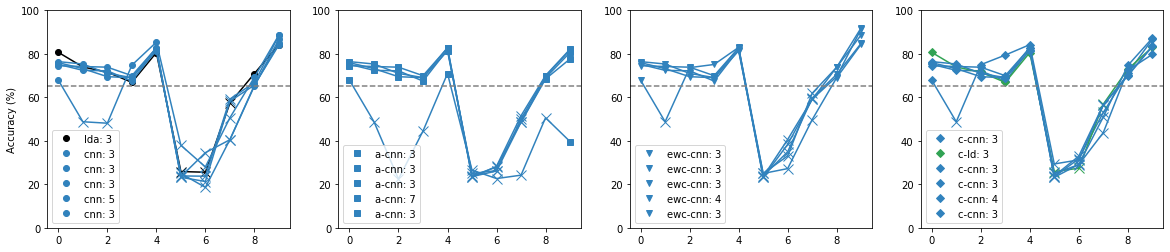

In [3]:
cv_iter = 5
for sub in range(1):#5):
    fig,ax = plt.subplots(1,4,figsize=(20,4))
    for it in range(cv_iter):
        with open(subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
            acc_all, recal_all = pickle.load(f)

        colors =  cm.get_cmap('tab20c')
        c = np.empty((20,4))
        for i in range(20):
            c[i,:] = colors(i*1/20)

        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
        nn_c[0,-1] = 1
        all_m = ['ko-','o-','o-','s-','s-','v-','v-']
        pt_m = ['ko','o','o','s','s','v','v','D','D','D']

        labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']

        # d0 = datetime(int(all_files[0][:4]),int(all_files[0][4:6]),int(all_files[0][6:8]),int(all_files[0][9:11]),int(all_files[0][11:13]),int(all_files[0][13:]))
        # delta = np.empty((len(acc_all)-1,1))
        # for i in range(1,len(acc_all)-1):
        #     d1 = datetime(int(all_files[i][:4]),int(all_files[i][4:6]),int(all_files[i][6:8]),int(all_files[i][9:11]),int(all_files[i][11:13]),int(all_files[i][13:]))
        #     delta[i] = (d1 - d0).total_seconds()
            
        ax_ind = [0,0,0,1,1,2,2,3,3,3]
        for i in [0,2,4,6,8,9]:#range(3):#acc_all.shape[-1]):
            acc_temp = acc_all[1:-1,i]
            if not np.isnan(acc_temp).all():
                x = np.arange(len(acc_temp))
                recal_i = (acc_temp < 0)
                ax[ax_ind[i]].plot(np.abs(acc_temp),'-',color=nn_c[i,:])
                ax[ax_ind[i]].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[i],label=labels[i]+': ' + str(int(recal_all[i,0])),color=nn_c[i,:])
                ax[ax_ind[i]].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[i,:])

    for i in range(4):
        ax[i].axhline(65, ls='--', color='grey')
        ax[i].legend()
        ax[i].set_ylim([0,100])
    ax[0].set_ylabel('Accuracy (%)')

In [ ]:
train_file = all_files[0]
train_file2 = all_files[1]
ft= 'feat'

train_data, train_params = prd.load_caps_train(path + train_file + '/traindata.mat')
train_data = train_data[:,:8,:]

train_dof = np.unique(train_params[:,2])
key = np.empty(train_dof.shape)
for i in range(len(train_dof)):
    key[i] = train_params[np.argmax(train_params[:,2] == train_dof[i]),0]

In [ ]:
train_data2, train_params2 = prd.load_caps_train(path + train_file2 + '/traindata.mat')
train_data2 = train_data2[:,:8,:]
train_data = np.vstack((train_data,train_data2))
train_params = np.vstack((train_params,train_params2))

In [ ]:
# Prep initial training data
ep = 30
n_dof = len(train_dof)

# train_data, train_params = prd.threshold(train_data, train_params)
trainmlp_0, traincnn_0, y_train_0, x_train_mlp_0, x_train_cnn_0, x_train_lda_0, y_train_lda_0, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b = False, batch_size=32,ft=ft, noise=True, split=False)
y_test_0, x_test_mlp_0, x_test_cnn_0, x_lda_0, y_lda_0 = prd.prep_test_caps(train_data, train_params, scaler, emg_scale, num_classes=len(train_dof),ft=ft, split=False)


In [ ]:
# Initial training
mlp, cnn, w, c = lp.train_models(traincnn_0, trainmlp_0, x_train_lda_0, y_train_lda_0, n_dof, ep=3)
mlp_0 = mlp.get_weights()
cnn_0 = cnn.get_weights()
w_0 = cp.deepcopy(w)
c_0 = cp.deepcopy(c)

In [ ]:
# LDA recalibration threshold
acc = np.empty((len(all_files),5))

for i in range(0,len(all_files)-1):
    # load data
    train_file = all_files[i]
    train_data, train_params = prd.load_caps_train(path + train_file + '/traindata.mat')
    train_data = train_data[:,:8,:]
    # train_data, train_params = prd.threshold(train_data, train_params)

    train_dof = np.unique(train_params[:,2])
    key = np.empty(train_dof.shape)
    for ki in range(len(train_dof)):
        key[ki] = train_params[np.argmax(train_params[:,2] == train_dof[ki]),0]

    _, _, _, _, _, x_train_lda_0, y_train_lda_0, _, _, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b=False, batch_size=32, ft=ft, noise=False, split=False, emg_scale=np.ones((train_data.shape[1],1)))

    _, _, w, c = lp.train_models(x_train_lda=x_train_lda_0, y_train_lda=y_train_lda_0)

    # load data
    test_file = all_files[i+1]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:]

    # test_data, test_params = prd.threshold(test_data, test_params)
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, ft=ft, split=False)
    acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, lda = [w, c])
    print ('Set: ' + test_file, f'LDA Accuracy: {acc[i,0]:.2f}')

In [ ]:
# Train and test on current dataset
acc = np.empty((len(all_files),5))
# old_train_mlp, old_train_cnn, old_x_train_lda, old_y_train_lda, old_y_train = [], [], [], [], []

for i in range(0,len(all_files)):
    train_file = all_files[i]
    train_data, train_params = prd.load_caps_train(path + train_file + '/traindata.mat')
    train_data = train_data[:,:8,:]

    orig_train_dof = np.unique(train_params[:,2])
    train_data, train_params = prd.threshold(train_data, train_params)
    train_dof = np.unique(train_params[:,2])

    if len(orig_train_dof) == len(train_dof):
        n_dof = len(train_dof)
        key = np.empty(train_dof.shape)
        for key_i in range(len(train_dof)):
            key[key_i] = cp.deepcopy(train_params[np.argmax(train_params[:,2] == train_dof[key_i]),0])

        trainmlp_0, traincnn_0, y_train_0, x_train_mlp_0, x_train_cnn_0, x_train_lda_0, y_train_lda_0, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b = False, batch_size=32, ft=ft, noise=False, split=True)

        if i > 0:
            x_train_mlp_0, x_train_cnn_0, x_train_lda_0, y_train_lda_0, y_train_0 = np.vstack((old_train_mlp, x_train_mlp_0)), np.vstack((old_train_cnn, x_train_cnn_0)), np.vstack((old_x_train_lda, x_train_lda_0)), np.vstack((old_y_train_lda, y_train_lda_0)), np.vstack((old_y_train, y_train_0))

            trainmlp_0 = tf.data.Dataset.from_tensor_slices((x_train_mlp_0, y_train_0, y_train_0)).shuffle(x_train_mlp_0.shape[0],reshuffle_each_iteration=True).batch(32)
            traincnn_0 = tf.data.Dataset.from_tensor_slices((x_train_cnn_0, y_train_0, y_train_0)).shuffle(x_train_cnn_0.shape[0],reshuffle_each_iteration=True).batch(32)

        mlp, cnn, w, c = lp.train_models(traincnn_0, trainmlp_0, x_train_lda_0, y_train_lda_0, n_dof, ep=30)

        # test 
        y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(train_data, train_params, scaler, emg_scale, num_classes=len(train_dof),ft=ft, split=True)
        acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c])
        print ('Set: ' + train_file, f'CNN Accuracy: {acc[i,2]:.2f},', f'MLP Accuracy: {acc[i,1]:.2f},', f'LDA Accuracy: {acc[i,0]:.2f}')
        old_train_mlp, old_train_cnn, old_x_train_lda, old_y_train_lda, old_y_train = x_train_mlp_0, x_train_cnn_0, x_train_lda_0, y_train_lda_0, y_train_0
    else:
        print('Skipping ' + train_file)

In [ ]:
# Train on initial, test without recalibration or adaptation
acc = np.empty((len(all_files),5))

for i in range(0,len(all_files)):
    # load data
    test_file = all_files[i]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:]

    # test_data, test_params = prd.threshold(test_data, test_params)
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=len(train_dof),ft=ft, split=False)
    acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c])
    print ('Set: ' + test_file, f'CNN Accuracy: {acc[i,2]:.2f},', f'MLP Accuracy: {acc[i,1]:.2f},', f'LDA Accuracy: {acc[i,0]:.2f}')

In [ ]:
ewc_acc = np.empty((len(all_files),5))
ewc_acc[:] = np.nan
rec_acc = np.empty((len(all_files),5))
rec_acc[:] = np.nan

n_dof = len(train_dof)

cnn.set_weights(cnn_0)
mlp.set_weights(mlp_0)

ewc_cnn = dl.EWC(mod='CNN')
ewc_cnn(x_train_cnn_0[:1,...])
loss, fish_loss = lp.train_task(ewc_cnn, ep, 1, x_train_cnn_0,y_train_0, [x_test_cnn_0],[y_test_0], lams=[0])
x_test_ewc_cnn_0 = cp.deepcopy(x_test_cnn_0)
y_test_ewc_0 = cp.deepcopy(y_test_0)
x_val_ewc_cnn = cp.deepcopy(x_test_cnn_0)
y_val_ewc = cp.deepcopy(y_test_0)

ewc = dl.EWC()
ewc(x_train_mlp_0[:1,...])
loss, fish_loss = lp.train_task(ewc, ep, 1, x_train_mlp_0,y_train_0, [x_test_mlp_0],[y_test_0], lams=[0])
x_test_ewc_0 = cp.deepcopy(x_test_mlp_0)
x_val_ewc = cp.deepcopy(x_test_mlp_0)

ewc_acc[0,:] = lp.test_models(x_test_cnn_0, x_test_mlp_0, x_lda_0, y_test_0, y_lda_0, cnn, mlp, [w, c], ewc, ewc_cnn)
print(ewc_acc[0,:])

for i in range(1,len(all_files)-1,1):
    # load recalibration data
    ewc_file = all_files[i]
    ewc_data, ewc_params = prd.load_caps_train(path + ewc_file + '/traindata.mat')
    ewc_data = ewc_data[:,:8,:]

    ewc_cnn.compute_fisher(x_val_ewc_cnn, y_val_ewc, num_samples=200, plot_diffs=False) # use validation set for Fisher computation
    ewc_cnn.star()

    ewc.compute_fisher(x_val_ewc, y_val_ewc, num_samples=200, plot_diffs=False) # use validation set for Fisher computation
    ewc.star()

    # check class labels
    orig_train_dof = np.unique(ewc_params[:,2])
    ewc_data, ewc_params = prd.threshold(ewc_data, ewc_params)
    train_dof = np.unique(ewc_params[:,2])

    if len(orig_train_dof) == len(train_dof):
        # n_dof = len(train_dof)
        
        # training data
        ewcmlp, ewccnn, y_train_ewc, x_train_ewc, x_train_ewc_cnn, x_train_lda, y_train_lda, _, _, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, num_classes=n_dof, batch_size=32, noise=True, scaler=scaler, emg_scale=emg_scale,ft=ft,split=True)
        # training data for recalibration
        rmlp, rcnn, y_train_r, x_train_r, x_train_r_cnn, x_train_r_lda, y_train_r_lda, r_emg_scale, r_scaler, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, batch_size=32, noise=True, ft=ft, split=True)
        # validation data for fisher
        _, _, y_val_ewc, x_val_ewc, x_val_ewc_cnn, _, _, _, _, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, num_classes=n_dof, batch_size=32, noise=False, scaler=scaler, emg_scale=emg_scale,ft=ft,split=True)
        # test data
        y_test_ewc, x_test_ewc, x_test_ewc_cnn, x_lda, y_lda = prd.prep_test_caps(ewc_data, ewc_params, scaler, emg_scale, num_classes=n_dof,ft=ft,split=True)
        # test data for recalibration
        y_test_r, x_test_r, x_test_r_cnn, x_r_lda, y_r_lda = prd.prep_test_caps(ewc_data, ewc_params, r_scaler, r_emg_scale, ft=ft,split=True)

        loss, fish_loss = lp.train_task(ewc_cnn, 30, 1, x_train_ewc_cnn, y_train_ewc, [x_test_ewc_cnn_0, x_test_ewc_cnn], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
        loss, fish_loss = lp.train_task(ewc, 30, 1, x_train_ewc, y_train_ewc, [x_test_ewc_0, x_test_ewc], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
        mlp, cnn, _, _ = lp.train_models(ewccnn, ewcmlp, n_dof=n_dof, ep=5, mlp=mlp, cnn=cnn)

        mlp_r, cnn_r, w, c = lp.train_models(rcnn, rmlp, x_train_r_lda, y_train_r_lda, n_dof=n_dof, ep=30)

        # test
        ewc_acc[i,:] = lp.test_models(x_test_ewc_cnn, x_test_ewc, x_lda, y_test_ewc, y_lda, cnn, mlp, ewc=ewc, ewc_cnn=ewc_cnn)
        rec_acc[i,:] = lp.test_models(x_test_r_cnn, x_test_r, x_r_lda, y_test_r, y_r_lda, cnn_r, mlp_r, lda=[w,c])

        x_test_ewc_cnn_0 = cp.deepcopy(x_test_ewc_cnn)
        x_test_ewc_0 = cp.deepcopy(x_test_ewc)
        y_test_ewc_0 = cp.deepcopy(y_test_ewc)

        print ('EWC: ' + ewc_file + ',', f'EWC CNN Accuracy: {ewc_acc[i,4]:.2f},', f'EWC Accuracy: {ewc_acc[i,3]:.2f},', f'a-CNN Accuracy: {ewc_acc[i,2]:.2f},', f'a-MLP Accuracy: {ewc_acc[i,1]:.2f},',  f'r-CNN Accuracy: {rec_acc[i,2]:.2f},', f'r-MLP Accuracy: {rec_acc[i,1]:.2f},', f'r-LDA Accuracy: {rec_acc[i,0]:.2f}')
    else:
        print('Skipping ' + ewc_file)

In [ ]:
# Test all controllers with ewc
ep = 30
# Remove extra file if odd number of files
if len(all_files)%2 == 0:
    all_files = np.delete(all_files,-1)
ewc_acc = np.empty((len(all_files),5))
ewc_acc[:] = np.nan
rec_acc = np.empty((len(all_files),5))
rec_acc[:] = np.nan

n_dof = len(train_dof)

cnn.set_weights(cnn_0)
mlp.set_weights(mlp_0)

ewc_cnn = dl.EWC(mod='CNN')
ewc_cnn(x_train_cnn_0[:1,...])
loss, fish_loss = lp.train_task(ewc_cnn, ep, 1, x_train_cnn_0, y_train_0, [x_test_cnn_0],[y_test_0], lams=[0])
x_test_ewc_cnn_0 = cp.deepcopy(x_test_cnn_0)
y_test_ewc_0 = cp.deepcopy(y_test_0)
x_val_ewc_cnn = cp.deepcopy(x_test_cnn_0)
y_val_ewc = cp.deepcopy(y_test_0)

ewc = dl.EWC()
ewc(x_train_mlp_0[:1,...])
loss, fish_loss = lp.train_task(ewc, ep, 1, x_train_mlp_0, y_train_0, [x_test_mlp_0],[y_test_0], lams=[0])
x_test_ewc_0 = cp.deepcopy(x_test_mlp_0)
x_val_ewc = cp.deepcopy(x_test_mlp_0)

ewc_acc[0,:] = lp.test_models(x_test_cnn_0, x_test_mlp_0, x_lda_0, y_test_0, y_lda_0, cnn, mlp, [w_0, c_0], ewc, ewc_cnn)

for i in range(7,len(all_files)-1,2):
    # load recalibration data
    ewc_file = all_files[i]
    ewc_data, ewc_params = prd.load_caps_train(path + ewc_file + '/traindata.mat')
    ewc_data = ewc_data[:,:8,:]

    ewc_cnn.compute_fisher(x_val_ewc_cnn, y_val_ewc, num_samples=200, plot_diffs=False) # use validation set for Fisher computation
    ewc_cnn.star()

    ewc.compute_fisher(x_val_ewc, y_val_ewc, num_samples=200, plot_diffs=False) # use validation set for Fisher computation
    ewc.star()

    orig_train_dof = np.unique(ewc_params[:,2])
    ewc_data, ewc_params = prd.threshold(ewc_data, ewc_params)
    train_dof = np.unique(ewc_params[:,2])

    if len(orig_train_dof) == len(train_dof):

        # check class labels
        ewc_data, ewc_params = lp.check_labels(ewc_data, ewc_params, train_dof, key)
        
        ewcmlp, ewccnn, y_train_ewc, x_train_ewc, x_train_ewc_cnn, x_train_lda, y_train_lda, _, _, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, num_classes=n_dof, batch_size=64, noise=True, scaler=scaler, emg_scale=emg_scale,ft=ft, split=True)
        _, _, y_val_ewc, x_val_ewc, x_val_ewc_cnn, _, _, _, _, _, _, _= prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, num_classes=n_dof, batch_size=64, noise=False, scaler=scaler, emg_scale=emg_scale,ft=ft, split=True)

        y_test_ewc, x_test_ewc, x_test_ewc_cnn, x_lda, y_lda = prd.prep_test_caps(ewc_data, ewc_params, scaler, emg_scale, num_classes=n_dof,ft=ft, split=True)

        loss, fish_loss = lp.train_task(ewc_cnn, 30, 1, x_train_ewc_cnn, y_train_ewc, [x_test_ewc_cnn_0, x_test_ewc_cnn], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
        loss, fish_loss = lp.train_task(ewc, 30, 1, x_train_ewc, y_train_ewc, [x_test_ewc_0, x_test_ewc], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
        mlp, cnn, _, _ = lp.train_models(ewccnn, ewcmlp, x_train_lda, y_train_lda, n_dof, 30, mlp, cnn)
        
        # training data for recalibration
        rmlp, rcnn, y_train_r, x_train_r, x_train_r_cnn, x_train_r_lda, y_train_r_lda, r_emg_scale, r_scaler, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, batch_size=32, noise=True, ft=ft, split=True)
        y_test_r, x_test_r, x_test_r_cnn, x_r_lda, y_r_lda = prd.prep_test_caps(ewc_data, ewc_params, r_scaler, r_emg_scale, ft=ft, split=True)

        mlp_r, cnn_r, w, c = lp.train_models(rcnn, rmlp, x_train_r_lda, y_train_r_lda, ep=30)

        # load test data
        test_file = all_files[i+1]
        test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
        test_data = test_data[:,:8,:]
        
        # check class labels
        test_data, test_params = prd.threshold(test_data, test_params)
        test_data, test_params = lp.check_labels(test_data, test_params, train_dof, key)

        ewc_acc[i,:] = lp.test_models(x_test_ewc_cnn, x_test_ewc, x_lda, y_test_ewc, y_lda, cnn, mlp, ewc=ewc, ewc_cnn=ewc_cnn)
        rec_acc[i,:] = lp.test_models(x_test_r_cnn, x_test_r, x_r_lda, y_test_r, y_r_lda, cnn_r, mlp_r, lda=[w,c])

        # test 
        y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof, ft=ft)
        y_test_r, x_test_r, x_test_r_cnn, x_r_lda, y_r_lda = prd.prep_test_caps(test_data, test_params, r_scaler, r_emg_scale, num_classes=n_dof,ft=ft)
        ewc_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, ewc=ewc, ewc_cnn=ewc_cnn)
        rec_acc[i+1,:] = lp.test_models(x_test_r_cnn, x_test_r, x_r_lda, y_test_r, y_r_lda, cnn_r, mlp_r, lda=[w,c])

        x_test_ewc_cnn_0 = cp.deepcopy(x_test_ewc_cnn)
        x_test_ewc_0 = cp.deepcopy(x_test_ewc)
        y_test_ewc_0 = cp.deepcopy(y_test_ewc)

        print ('EWC: ' + ewc_file + ', Test: ' + test_file + ',', f'EWC CNN Accuracy: {ewc_acc[i+1,4]:.2f},', f'EWC Accuracy: {ewc_acc[i+1,3]:.2f},', f'a-CNN Accuracy: {ewc_acc[i+1,2]:.2f},', f'a-MLP Accuracy: {ewc_acc[i+1,1]:.2f},',  f'r-CNN Accuracy: {rec_acc[i+1,2]:.2f},', f'r-MLP Accuracy: {rec_acc[i+1,1]:.2f},', f'r-LDA Accuracy: {rec_acc[i+1,0]:.2f}')
    else:
        print('Skipping: ' + ewc_file)

In [ ]:
ewc_acc[0,...] = np.nan
rec_acc[0,...] = np.nan
rlda_acc = np.empty((len(all_files),15))
rlda_acc[:] = np.nan
lda_acc = np.empty((len(all_files),15))
lda_acc[:] = np.nan
acc_all = np.hstack((acc[:,...],ewc_acc,rec_acc))
for i in range(acc.shape[1]):
    rlda_acc[:,i] = acc[:,i] - ewc_acc[:,0]
    rlda_acc[:,i+5] = ewc_acc[:,i] - ewc_acc[:,0]
    rlda_acc[:,i+10] = rec_acc[:,i] - ewc_acc[:,0]

    lda_acc[:,i] = acc[:,i] - acc[:,0]
    lda_acc[:,i+5] = ewc_acc[:,i] - acc[:,0]
    lda_acc[:,i+10] = rec_acc[:,i] - acc[:,0]

In [ ]:
lda_i = [0, 5]
cnn_i = [2, 12, 7, 9]
mlp_i = [1, 11, 6, 8]
nn_i = np.vstack((mlp_i,cnn_i))

colors =  cm.get_cmap('tab20c')
c = np.empty((20,4))
for i in range(20):
    c[i,:] = colors(i*1/20)

mlp_c = np.vstack((c[8,:],c[9,:],c[10,:],c[11,:]))
cnn_c = np.vstack((c[0,:],c[1,:],c[2,:],c[3,:]))
nn_c = np.stack((mlp_c,cnn_c))
lda_c = ['ko-','ko--']
nn_m = ['o-','s-','v-','x-']

In [ ]:
mask = ~np.isnan(rlda_acc)

for mod in range(nn_i.shape[0]):
    i_ = nn_i[mod,...]
    fig,ax = plt.subplots(1,3,figsize=(16,4))

    # for i in range(len(lda_i)):
        # ax[0].plot(acc_all[mask[:,lda_i[i]],lda_i[i]][1::2], lda_c[i])
    for i in range(len(i_)):
        ax[0].plot(acc_all[mask[:,i_[i]],i_[i]][1::2], nn_m[i], color=nn_c[mod,i,:])
        ax[1].plot(rlda_acc[mask[:,i_[i]],i_[i]][1::2], nn_m[i], color=nn_c[mod,i,:])
        ax[2].plot(lda_acc[mask[:,i_[i]],i_[i]][1::2], nn_m[i], color=nn_c[mod,i,:])

    if mod == 0:
        ax[0].legend(['LDA', 'r-LDA', 'MLP', 'r-MLP', 'a-MLP', 'ewc-MLP'])
        ax[1].legend(['MLP vs. r-LDA', 'r-MLP vs. r-LDA', 'a-MLP vs. r-LDA', 'ewc-MLP vs. r-LDA'])
        ax[2].legend(['MLP vs. LDA', 'r-MLP vs. LDA', 'a-MLP vs. LDA', 'ewc-MLP vs. LDA'])
    else:
        ax[0].legend(['LDA', 'r-LDA', 'CNN', 'r-CNN', 'a-CNN', 'ewc-CNN'])
        ax[1].legend(['CNN vs. r-LDA', 'r-CNN vs. r-LDA', 'a-CNN vs. r-LDA', 'ewc-CNN vs. r-LDA'])
        ax[2].legend(['CNN vs. LDA', 'r-CNN vs. LDA', 'a-CNN vs. LDA', 'ewc-CNN vs. LDA'])

    ax[0].set_ylim([0,100])
    ax[1].axhline(0, ls = '--',color='black')
    ax[2].axhline(0, color='black')

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
x = range(0,acc.shape[0]-2,1)
x_skip = range(0,acc.shape[0]-2,2)

for i in range(3):
    ax[0].plot(x_skip,acc[2::2,i],'o', label='_nolegend_')
    ax[0].plot(x,acc[2:,i],'-')

    if i == 0:
        ls = 's--'
    else:
        ls = 's-'
    ax[1].plot(x_skip,recal_acc[mask,i], ls)

    if i > 0:
        ax[2].plot(x_skip,adapt_acc[mask,i], 'v-')

    ax[i].set_ylim([0,100])

ax[0].legend(['LDA','MLP','CNN'])
ax[1].legend(['r-LDA','r-MLP','r-CNN'])
ax[2].legend(['a-MLP','a-CNN'])  

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
x = range(0,acc.shape[0]-2,1)
x_skip = range(0,acc.shape[0]-2,2)

for i in range(3):
    ax[0].plot(x_skip,acc[2::2,i],'o',color=col[i,:], label='_nolegend_')
    ax[0].plot(x,acc[2:,i],'-',color=col[i,:])

    if i == 0:
        ls = 's--'
    else:
        ls = 's-'
    ax[1].plot(x_skip,recal_acc[mask,i], ls,color=col[i,:])

    if i > 0:
        ax[2].plot(x_skip,adapt_acc[mask,i], 'v-',color=col[i,:])

    ax[i].set_ylim([0,100])

ax[0].legend(['LDA','MLP','CNN'])
ax[1].legend(['r-LDA','r-MLP','r-CNN'])
ax[2].legend(['a-MLP','a-CNN'])  

In [ ]:
# Test all controllers with adaptation
ep = 30
# Remove extra file if odd number of files
# if len(all_files)%2 == 0:
#     all_files = np.delete(all_files,-1)
align_acc = np.empty((len(all_files),5))
align_acc[:] = np.nan
n_dof = len(train_dof)

for i in range(2,len(all_files)-1):
    # load recalibration data
    align_file = all_files[i]
    align_data, align_params = prd.load_caps_train(path + align_file + '/traindata.mat')
    align_data = align_data[:,:8,:]

    # check class labels
    align_data, align_params = prd.threshold(align_data, align_params)
    align_data, align_params = lp.check_labels(align_data, align_params, train_dof, key)
    
    alignmlp, aligncnn, _, _, _, x_train_lda, y_train_lda, _, _, _, _, _ = prd.prep_train_caps(align_data, align_params, prop_b = False, num_classes=n_dof, batch_size=32, noise=False, scaler=scaler, emg_scale=emg_scale,ft=ft,split=True)
    mlp, cnn, mlp_ali, cnn_ali, w, c = lp.train_models(aligncnn, alignmlp, x_train_lda, y_train_lda, n_dof, ep, mlp, cnn, align=True)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(align_data, align_params, scaler, emg_scale, num_classes=n_dof,ft=ft, split=True)
    align_acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c], cnn_align=cnn_ali, mlp_align=mlp_ali)

    print ('Align: ' + align_file + ',', f'CNN Accuracy: {align_acc[i,2]:.2f},', f'MLP Accuracy: {align_acc[i,1]:.2f},', f'LDA Accuracy: {align_acc[i,0]:.2f}')